<a href="https://www.kaggle.com/code/limonhalder/binary-segmentation-using-u-net?scriptVersionId=109113348" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import required libraires

In [1]:
import os 
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob

In [2]:
img_directory=""
mask_directory=""
size=256
num_img=999

# Preprocessing for images and mask

In [3]:
image_names=glob.glob("../input/fetal-head-circumference-data/Fetal Head Circumference/train_set/Images/*.png")

image_names.sort()

print(len(image_names))
image_names_subset=image_names[0:num_img]
images=[cv2.imread(img,0) for img in image_names_subset]
images=[cv2.resize(img,(256,256)) for img in images]
image_dataset=np.array(images)
print(image_dataset.shape)

image_dataset=np.expand_dims(image_dataset, axis=3)

999
(999, 256, 256)


In [5]:
mask_names=glob.glob("../input/fetal-head-circumference-data/Fetal Head Circumference/train_set/Annotation/*.png")

mask_names.sort()
mask_names_subset=mask_names[0:num_img]
masks=[cv2.imread(mask,0) for mask in mask_names_subset]
masks=[cv2.resize(mask,(256,256)) for mask in masks]
mask_dataset=np.array(masks)
mask_dataset=np.expand_dims(mask_dataset, axis=3)


In [6]:
mask_dataset.shape

(999, 256, 256, 1)

In [7]:
image_dataset=image_dataset/256
mask_dataset=mask_dataset/256



# Spliting data into train and test

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(image_dataset,mask_dataset, test_size=.2, random_state=42)

# chenity check

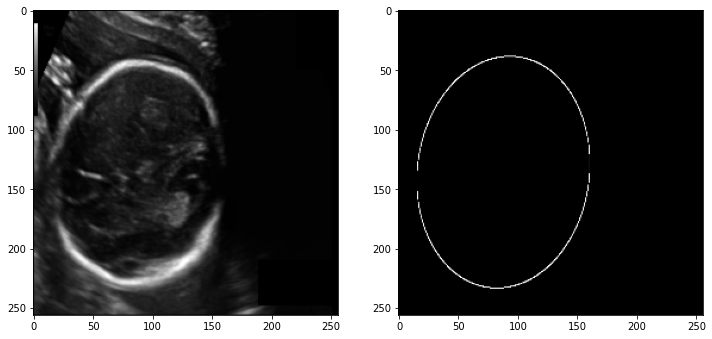

In [9]:
import random
image_number=random.randint(0,len(X_train))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0],cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap="gray")
plt.show()

In [10]:
X_train[image_number,:,:,0].shape

(256, 256)

In [11]:
from keras.models import Model
from keras.layers.convolutional import  Conv2D, MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPooling2D, Concatenate,Input, BatchNormalization,Dropout,Lambda


# Convolution block with 2 conv layers and batch normalization for each layer

In [12]:
def conv_block(input, num_filters):
    x=Conv2D(num_filters,3,padding="same")(input)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    
    x=Conv2D(num_filters,3,padding="same")(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    return x

# Encoder Block and decoder block 

In [13]:
def encoder_block(input, num_filters):
    x=conv_block(input,num_filters)
    p=MaxPooling2D((2,2))(x)
    
    return x,p




def decoder_block(input,skip_feature, num_filters):
    x=Conv2DTranspose(num_filters,(2,2),strides=2, padding="same")(input)
    x=Concatenate()([x,skip_feature])
    x=conv_block(x,num_filters)
    return x




    

# Build U-net bloack using encoder nad decoder block

In [14]:
def build_unet(input_shape, n_classes):
    inputs=Input(input_shape)
    
    s1,p1=encoder_block(inputs,64)
    s2,p2=encoder_block(p1,128)
    s3,p3=encoder_block(p2,256)
    s4,p4=encoder_block(p3,512)
    
    
    b1=conv_block(p4,1024) # bridge
    
    
    d1=decoder_block(b1,s4,512)
    d2=decoder_block(d1,s3,256)
    d3=decoder_block(d2, s2,128)
    d4=decoder_block(d3,s1,64)
    
    if n_classes==1:
        activation="sigmoid"
        
    else:
        activation="softmax"
    
    
    
    outputs=Conv2D(n_classes,1,padding="same",activation=activation)(d4)
    
    
    model=Model(inputs,outputs,name="U-Net")
    
    return model
    
    

In [16]:
Img_height=image_dataset.shape[1]
Img_width=image_dataset.shape[2]
Img_channel=image_dataset.shape[3]
input_shape=(Img_height,Img_width,Img_channel)


In [17]:
Img_height

256

In [18]:
model=build_unet(input_shape,n_classes=1)
model.summary()

2022-10-25 17:28:43.907901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 17:28:44.049364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 17:28:44.050260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 17:28:44.051328: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=["accuracy"])

# History

In [26]:
history=model.fit(X_train,y_train,
                 batch_size=3,
                 verbose=1,
                 epochs=3,
                 validation_data=(X_test,y_test),
                 shuffle=False)

Epoch 1/3
267/267 [==============================] - 30s 113ms/step - loss: 0.1056 - accuracy: 0.9889 - val_loss: 0.0952 - val_accuracy: 0.9888
Epoch 2/3
267/267 [==============================] - 30s 112ms/step - loss: 0.0803 - accuracy: 0.9889 - val_loss: 0.0728 - val_accuracy: 0.9888
Epoch 3/3
267/267 [==============================] - 30s 112ms/step - loss: 0.0643 - accuracy: 0.9889 - val_loss: 0.0601 - val_accuracy: 0.9888


In [115]:
s=X_test[8]

In [117]:
predicts=model.predict(X_test)


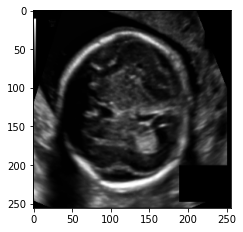

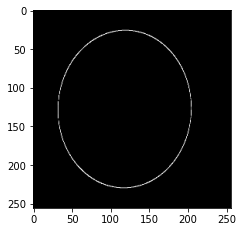

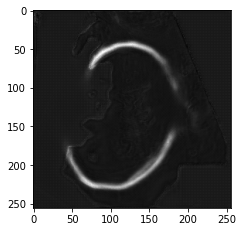

In [118]:
thrshold=0
test_img_number=random.randint(0,len(X_test))
test_img=X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_image_input=np.expand_dims(test_img,0)
predictio=(model.predict(test_image_input)[0,:,:,:]>.15).astype(np.uint8)
#predictio=(model.predict(test_image_input)[0,:,:,:]>.15)


plt.figure(figsize=(16,8))
plt.title("testing Image")
plt.subplot(221)
plt.imshow(test_img[:,:,:],cmap='gray')

plt.figure(figsize=(16,8))
plt.title("true value")
plt.subplot(222)
plt.imshow(ground_truth[:,:,:],cmap='gray')


plt.figure(figsize=(16,8))
plt.title("predicted")
plt.subplot(223)
plt.imshow(predicts[6],cmap='gray')
plt.show()

In [25]:
predictio.shape

(256, 256, 1)

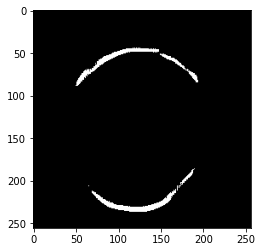

In [26]:
plt.imshow(predictio,cmap='gray')

predictio and ground are in different data type. thats why can not be substract

In [28]:
X_test.shape[0]

200

# Prediction for whole dataset

In [20]:
predicts=model.predict(X_test)

In [119]:
predicts.shape

(200, 256, 256, 1)

In [95]:
predict2=[]
masks=[]

def prediction(image_dataset):
    for i in range(image_dataset.shape[0]):
        test_img=image_dataset[i]
        ground_truth=mask_dataset[i]
        test_image_input=np.expand_dims(test_img,0)
        predict=(model.predict(test_image_input)[0,:,:,:]>.141).astype("float32")
        predict2.append(predict)
        
    return predict2    

In [96]:
#predicts2=prediction(X_test)

In [98]:
 predicts= np.array(predicts)

In [99]:
predicts2.shape

(200, 256, 256, 1)

In [64]:
X_test.shape

(200, 256, 256, 1)

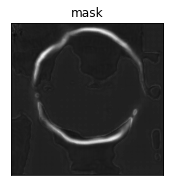

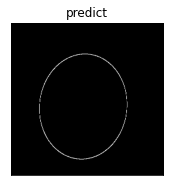

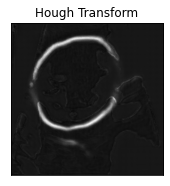

In [123]:
plt.subplot(122),plt.imshow(predicts[3], cmap='gray')
plt.title('mask'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(122),plt.imshow(y_test[73], cmap='gray')
plt.title('predict'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(122),plt.imshow(predicts[0], cmap='gray')
plt.title('Hough Transform'), plt.xticks([]), plt.yticks([])
plt.show()

# MSE error mesurement

In [124]:
#img1 = cv2.imread('')
#img2 = cv2.imread(prediction)

# convert the images to grayscale
#
#
#img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# define the function to compute MSE between two images
def mse(img1, img2):
   h, w = img1.shape
   diff = cv2.subtract(img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse



In [125]:
ERROR1=[]
def MSE(masks, predicts):
  
    masks=[np.asarray(mask, np.float64) for mask in masks]
    masks=[img[:,:,0] for img in masks]
    

    preds=[np.asarray(pred, np.float64) for pred in predicts]
    preds=[img[:,:,0] for img in preds ]
    
    
    
    for mask , pred in zip(masks, preds):
        error=mse(mask,pred)
        ERROR1.append(error)
    return ERROR1

In [126]:
ERROR2=[]
def MSE2(masks, predicts):
  
    masks=[np.asarray(mask, np.float64) for mask in masks]
    masks=[img[:,:,0] for img in masks]
    

    preds=[np.asarray(pred, np.float64) for pred in predicts]
    preds=[img[:,:,0] for img in preds ]
    
    
    
    for mask , pred in zip(masks, preds):
        error=mse(mask,pred)
        ERROR2.append(error)
    return ERROR2

In [88]:
#MSE(X_test,y_test)

In [127]:
error = MSE(y_test,predicts2)
print("Image matching Error between the two images:",error)

Image matching Error between the two images: [0.005689790938049555, 0.009092615451663733, 0.003023841418325901, 0.007588107837364078, 0.006582979112863541, 0.006124100415036082, 0.006507638143375516, 0.007422576425597072, 0.005571499466896057, 0.006885976064950228, 0.00665200874209404, 0.008175107883289456, 0.004902523010969162, 0.007229500450193882, 0.005769954761490226, 0.004890775308012962, 0.006741684395819902, 0.006210904801264405, 0.007811444578692317, 0.005975937470793724, 0.0072384176310151815, 0.007090098923072219, 0.006441125879064202, 0.006130350986495614, 0.007654242683202028, 0.0031515539158135653, 0.005567206535488367, 0.007978914771229029, 0.007037181407213211, 0.007210280513390899, 0.007508748210966587, 0.006800682749599218, 0.006545726442709565, 0.006677961442619562, 0.005654091946780682, 0.005520677426829934, 0.006765703670680523, 0.006238458910956979, 0.0058676982298493385, 0.006889121141284704, 0.00392727623693645, 0.006070353090763092, 0.005614225985482335, 0.00618

# Hough Transform

In [102]:
predicts=model.predict(X_test)

In [128]:
predicts.shape

(200, 256, 256, 1)

In [80]:
predicts2.dtype

dtype('float32')

In [129]:
predicts=predicts*256

In [130]:
predicts.dtype

dtype('float32')

In [131]:
predicts=predicts.astype('uint8')

In [132]:
predicts.dtype

dtype('uint8')

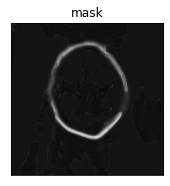

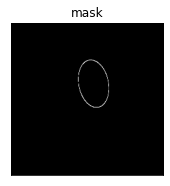

In [133]:
bgr_img=predicts[8]
plt.subplot(122),plt.imshow(bgr_img, cmap='gray')
plt.title('mask'), plt.xticks([]), plt.yticks([])
plt.show()
bgr_img=predicts2[0]
plt.subplot(121),plt.imshow(mask_dataset[9], cmap='gray')
plt.title('mask'), plt.xticks([]), plt.yticks([])
plt.show()

In [136]:
bgr_img=predicts[110]

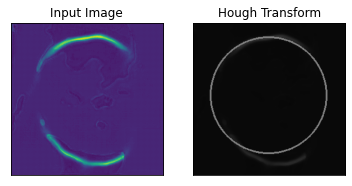

In [137]:
if bgr_img.shape[-1] == 3:           # color image
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
else:
    gray_img = bgr_img

img = cv2.medianBlur(gray_img, 5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
#cimg=gray_img
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,500,
                            param1=1,param2=3,minRadius=0,maxRadius=0)

circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(128,128,128),2)
    # draw the center of the circle
    #cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plt.subplot(121),plt.imshow(bgr_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cimg)
plt.title('Hough Transform'), plt.xticks([]), plt.yticks([])
plt.show()

In [138]:
Hough_pred=[]
def Hough_transform1(predicts):
    for j in range(200):
        #img= predicts[j]
        bgr_img=predicts[j]
        if bgr_img.shape[-1] == 3:           # color image
            b,g,r = cv2.split(bgr_img)       # get b,g,r
            rgb_img = cv2.merge([r,g,b])     # switch it to rgb
            gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
        else:
            gray_img = bgr_img

        img = cv2.medianBlur(gray_img, 3)
        cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
#cimg=gray_img
        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,500,
                            param1=1,param2=3,minRadius=0,maxRadius=0)

        circles = np.uint16(np.around(circles))

        for i in circles[0,:]:
    # draw the outer circle
            cv2.circle(cimg,(i[0],i[1]),i[2],(128,128,128),2)
    # draw the center of the circle
    #cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

        
        Hough_pred.append(cimg)
    return Hough_pred    

In [ ]:
predicts=model.predict(X_test)

In [139]:
predicts[110].dtype

dtype('uint8')

In [ ]:
X_test

# predicts=model.predict(X_test) aita diye predict korleocircle payoajasse thresholding kora lagtese na

In [140]:
Hough_preds=Hough_transform1(predicts)

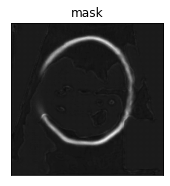

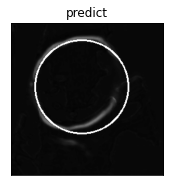

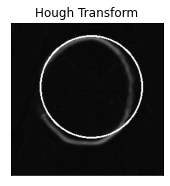

In [156]:
plt.subplot(122),plt.imshow(predicts[4],cmap='gray')
plt.title('mask'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(122),plt.imshow(Hough_preds[0], cmap='gray')
plt.title('predict'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(122),plt.imshow(Hough_preds[4], cmap='gray')
plt.title('Hough Transform'), plt.xticks([]), plt.yticks([])
plt.show()

In [144]:
len(Hough_pred)

200

In [145]:
y_test.shape

(200, 256, 256, 1)

In [89]:
gray_img = cv2.cvtColor(Hough_preds[4], cv2.COLOR_BGR2GRAY)

In [147]:
Hough_predlist=[]
for i in range(200):
    gray_img = cv2.cvtColor(Hough_preds[i], cv2.COLOR_BGR2GRAY)
    
    Hough_predlist.append(gray_img)


In [148]:
 Hough_preds= np.array(Hough_predlist)

In [151]:
Hough_preds.shape

(200, 256, 256, 1)

In [150]:
Hough_preds=np.expand_dims(Hough_preds, axis=3)

In [105]:
y_test.shape

(200, 256, 256, 1)

In [152]:
Hough_preds=Hough_preds/256

In [153]:
error2 = MSE2(y_test,Hough_preds)


In [154]:
print("Image matching Error between the two images:",error2)

Image matching Error between the two images: [0.010590595891699195, 0.014201909536495805, 0.008465284015983343, 0.01675530942156911, 0.010934941004961729, 0.012363122776150703, 0.010806716745719314, 0.013494392624124885, 0.011546227382496, 0.01226387033239007, 0.012435740558430552, 0.01418473687954247, 0.011466971598565578, 0.01219500694423914, 0.011218216037377715, 0.011104130186140537, 0.011351814260706306, 0.011701601324602962, 0.01392228715121746, 0.011106810765340924, 0.01315830321982503, 0.01277048117481172, 0.012160132173448801, 0.01110120047815144, 0.013627194100990891, 0.009533710312098265, 0.011171353049576283, 0.01271124673075974, 0.012404609005898237, 0.014160021441057324, 0.01251774630509317, 0.013251597993075848, 0.012534060282632709, 0.011058551259338856, 0.010651498334482312, 0.012236861046403646, 0.012121968669816852, 0.011316275224089622, 0.0119212637655437, 0.011663835495710373, 0.010186044499278069, 0.013171909609809518, 0.010649877600371838, 0.010695020901039243, 0

# END

In [44]:
test_img_number=random.randint(0,len(X_test))
test_img=X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_image_input=np.expand_dims(test_img,0)
predictio=(model.predict(test_image_input)[0,:,:,:]>.0841).astype(np.uint8)


#bgr_img=predictio

In [242]:
bgr_img=predictio

In [247]:
predictio.dtype

dtype('uint8')

In [250]:
ground_truth=ground_truth.astype("uint8")

In [253]:
mse(ground_truth[:,:,0], predictio)

0.0

befor hough it should be converted


In [44]:
predicts=predicts.astype('uint8')

In [45]:
bgr_img=predicts[0]

In [46]:
if bgr_img.shape[-1] == 3:           # color image
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
else:
    gray_img = bgr_img

img = cv2.medianBlur(gray_img, 5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
#cimg=gray_img
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,500,
                            param1=1,param2=3,minRadius=0,maxRadius=0)

circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(128,128,128),2)
    # draw the center of the circle
    #cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plt.subplot(121),plt.imshow(bgr_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cimg)
plt.title('Hough Transform'), plt.xticks([]), plt.yticks([])
plt.show()

TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable rint method

In [ ]:
mse()

In [235]:
Hough_pred=[]
def Hough_transform1(predicts):
    for j in range(200):
        #img= predicts[j]
        bgr_img=predicts[j]
        if bgr_img.shape[-1] == 3:           # color image
            b,g,r = cv2.split(bgr_img)       # get b,g,r
            rgb_img = cv2.merge([r,g,b])     # switch it to rgb
            gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
        else:
            gray_img = bgr_img

        img = cv2.medianBlur(gray_img, 3)
        cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
#cimg=gray_img
        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,500,
                            param1=1,param2=3,minRadius=0,maxRadius=0)

        circles = np.uint16(np.around(circles))

        for i in circles[0,:]:
    # draw the outer circle
            cv2.circle(cimg,(i[0],i[1]),i[2],(128,128,128),2)
    # draw the center of the circle
    #cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

        
        Hough_pred.append(cimg)
    return Hough_pred    

In [226]:
predicts.shape

(200, 256, 256, 1)

In [218]:
len(predicts)

200

# problemm: loop e hough trasformation kaj kortese nah

In [236]:
Hough_preds=Hough_transform1(predicts)

TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable rint method

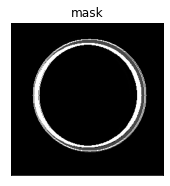

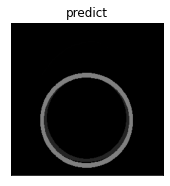

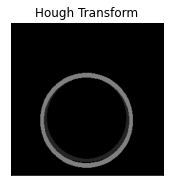

In [209]:
plt.subplot(122),plt.imshow(predicts[74], cmap='gray')
plt.title('mask'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(122),plt.imshow(Hough_preds[7], cmap='gray')
plt.title('predict'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(122),plt.imshow(Hough_preds[0], cmap='gray')
plt.title('Hough Transform'), plt.xticks([]), plt.yticks([])
plt.show()

In [119]:
len(Hough_pred)

146

In [82]:
len(error)

600

In [133]:
a=Hough_pred[4]
b=Hough_pred[2]

In [121]:
a.dtype

dtype('float64')

In [159]:
len()

TypeError: len() takes exactly one argument (0 given)

In [134]:
mse(a[:,:,0],b[:,:,0])

0.0

In [158]:
error = MSE2(masks,Hough_pred)
print("Image matching Error between the two images:",error)



Image matching Error between the two images: [592.5727577717043, 1052.5556302531622, 621.7865626597777, 708.8861438825261, 916.5482900179923, 718.7792472455185, 826.0387935668696, 891.3028657536488, 506.23295272886753, 726.3980089132674, 550.5064042918384, 806.1315207213629, 665.1405836753547, 925.5409617954865, 514.9027347431984, 488.2449874635786, 621.4995142635889, 925.564411383355, 621.1551246817689, 718.003025745973, 726.2375362215098, 639.9801143479999, 637.2887116766069, 630.4697063101921, 726.1848097373731, 668.2485399425495, 561.5608654157259, 667.9242219910957, 272.84315778687596, 646.5871839781757, 358.70848225895315, 550.5600753142498, 561.3768479267601, 709.0042286873795, 916.5975125981495, 387.5752860067878, 487.7979639573023, 830.3710522635374, 637.3517262721434, 512.7126022740267, 640.7656054950785, 592.6259648576379, 682.0697621752042, 646.5605717462022, 718.6605311189778, 916.5935700007249, 505.22583065438084, 539.3249608564656, 448.07262362958863, 396.49909666669555,

# prediction test dataset

In [ ]:
y_pred=model.predict(X_test)
y_pred_threshold=y_pred>0.5

# Determine MeanIoU

In [ ]:
from tensorflow.keras.metrics import MeanIoU


In [ ]:
n_classes=2
Iou_keras=MeanIoU(num_classes=n_classes)
Iou_keras.update_state(y_pred_threshold,y_test)
print("mean=",Iou_keras.result().numpy() )

In [ ]:
y_pred[7].shape

In [ ]:

plt.imshow(y_pred[7], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()